## Import dependencies

In [2]:
# Standard Library Imports
import os
import sys
from subprocess import call
import json
import time
import traceback
import asyncio
import aiohttp

# Third-Party Library Imports
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import webdataset as wds
import nibabel as nib
import pickle as pkl
from einops import rearrange
import torchvision.transforms as transforms
from PIL import Image
import torch
# import torchio as tio
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
# import SimpleITK as sitk

In [5]:
img.shape

(64, 64, 33, 300)

In [10]:
import os
import nibabel as nib
import boto3
import tqdm

s3 = boto3.resource('s3')
bucket_name = 'proj-fmri'
folder_path = 'fmri_foundation_datasets/parallel_openneuro/'

bucket = s3.Bucket(bucket_name)

iter = 0
total_TRs = 0

for obj in bucket.objects.filter(Prefix=folder_path):
    iter += 1
    if iter%200==0:
        print(f"iter {iter} / 167200 | {iter/167200} | TRs = {total_TRs}")
    if obj.key.endswith('.nii.gz'):
        # Download the file to a temporary location
        temp_file = '/tmp/' + os.path.basename(obj.key)
        bucket.download_file(obj.key, temp_file)

        # Load the NIfTI file using nibabel
        img = nib.load(temp_file)

        # Get the dimensions of the NIfTI file
        total_TRs += img.shape[-1]

        # Delete the temporary file
        os.remove(temp_file)

iter 200 / 167200 | 0.0011961722488038277 | TRs = 45290
iter 400 / 167200 | 0.0023923444976076554 | TRs = 86112
iter 600 / 167200 | 0.0035885167464114833 | TRs = 123138
iter 800 / 167200 | 0.004784688995215311 | TRs = 164984
iter 1000 / 167200 | 0.005980861244019139 | TRs = 204289
iter 1200 / 167200 | 0.007177033492822967 | TRs = 244379
iter 1400 / 167200 | 0.008373205741626795 | TRs = 286737
iter 1600 / 167200 | 0.009569377990430622 | TRs = 329012
iter 1800 / 167200 | 0.01076555023923445 | TRs = 371008
iter 2000 / 167200 | 0.011961722488038277 | TRs = 413025
iter 2200 / 167200 | 0.013157894736842105 | TRs = 455114
iter 2400 / 167200 | 0.014354066985645933 | TRs = 497243
iter 2600 / 167200 | 0.01555023923444976 | TRs = 539464
iter 2800 / 167200 | 0.01674641148325359 | TRs = 581458
iter 3000 / 167200 | 0.017942583732057416 | TRs = 654356
iter 3200 / 167200 | 0.019138755980861243 | TRs = 702245
iter 3400 / 167200 | 0.02033492822966507 | TRs = 766919


RuntimeError: Credentials were refreshed, but the refreshed credentials are still expired.

## Helper functions

In [ ]:
def reshape_to_2d(tensor):
    return rearrange(tensor, 'b h w c -> (b h) (c w)')

def reshape_to_original(tensor_2d, b=300, h=64, w=64, c=48):
    return rearrange(tensor_2d, '(b h) (c w) -> b h w c', b=b, h=h, w=w, c=c)

def header_to_dict(header):
    readable_header = {}
    for key, value in header.items():
        readable_header[key] = value
    return readable_header

def temporal_interp1d(fmri_data, change_TR):
    original_time_points = np.arange(fmri_data.shape[0])  # Time points: 0, 1, 2, ..., T-1
    new_time_points = np.arange(0, fmri_data.shape[0], change_TR)  # New time points: 0, 2, 4, ...

    reshaped_data = fmri_data.reshape(fmri_data.shape[0], -1)  # Reshape to (T, X*Y*Z)
    interpolate = interp1d(original_time_points, reshaped_data, kind='linear', axis=0, bounds_error=False, fill_value="extrapolate")
    resampled_fmri_data = interpolate(new_time_points).reshape((len(new_time_points),) + fmri_data.shape[1:])
    return resampled_fmri_data

def list_folders(bucket, prefix='', delimiter='/'):
    folder_names = []
    continuation_token = None
    while True:
        # Include the continuation token in the request if it exists
        kwargs = {'Bucket': bucket, 'Prefix': prefix, 'Delimiter': delimiter}
        if continuation_token:
            kwargs['ContinuationToken'] = continuation_token

        response = s3.list_objects_v2(**kwargs)
        folder_names.extend([x['Prefix'].split('/')[-2] for x in response.get('CommonPrefixes', [])])

        # Check if more items are available to retrieve
        if 'NextContinuationToken' in response:
            continuation_token = response['NextContinuationToken']
        else:
            break
    return folder_names

def list_all_objects(bucket, prefix):
    continuation_token = None
    while True:
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

        for content in response.get('Contents', []):
            yield content

        continuation_token = response.get('NextContinuationToken')
        if not continuation_token:
            break

def torchio_slice(data,xslice=None,yslice=None,zslice=None):    
    if xslice is None: xslice = data.shape[1] // 2
    if yslice is None: yslice = data.shape[2] // 2
    if zslice is None: zslice = data.shape[3] // 2

    fig, axs = plt.subplots(1, 3, figsize=(5,5))

    # Plot the three different slices
    axs[0].imshow(data[0, xslice], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f'Slice [0, {xslice}]', fontsize=8)

    axs[1].imshow(data[0, :, yslice], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f'Slice [0, :, {yslice}]', fontsize=8)

    axs[2].imshow(data[0, :, :, zslice], cmap='gray')
    axs[2].axis('off')
    axs[2].set_title(f'Slice [0, :, :, {zslice}]', fontsize=8)
    
    plt.show()
    
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

## Create dir to save dataset

In [ ]:
proj_name = "openneuro_raw"
outpath=f"/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/{proj_name}"
os.makedirs(os.path.dirname(outpath), exist_ok=True)
os.makedirs(f"{outpath}/tars", exist_ok=True)

## Sync metadata reference

```bash
aws s3 rm  s3://proj-fmri/fmri_foundation_datasets/conscioustahoe/openneuro/ --recursive

aws s3 cp s3://proj-fmri/fmri_foundation_datasets/openneuro/metadata.json s3://proj-fmri/fmri_foundation_datasets/conscioustahoe/openneuro/

aws s3 ls  s3://proj-fmri/fmri_foundation_datasets/conscioustahoe/openneuro/

aws s3 sync s3://proj-fmri/fmri_foundation_datasets/openneuro/tars s3://proj-fmri/fmri_foundation_datasets/conscioustahoe/openneuro
```

## Job

In [26]:
# Create a boto3 client without signing requests
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

Starting from scratch!
TR_count: 0
subj_count: 0
tar_count: 0
dataset_count: 0
deleting existing tars


rm: cannot remove '/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/openneuro_raw/tars/*.tar': No such file or directory


NUM_DATASETS: 1057 TRs_per_sample: 24 max_samples_per_tar: 320 max_TRs_per_tar: 7680
Processing dataset: ds000001.
ds000001/sub-01/func/sub-01_task-balloonanalogrisktask_run-01_bold.nii.gz (64, 64, 33, 300) | TRs: 0 samp: 0
ds000001/sub-01/func/sub-01_task-balloonanalogrisktask_run-01_bold.nii.gz | TR_count: 0 sample_idx: 0


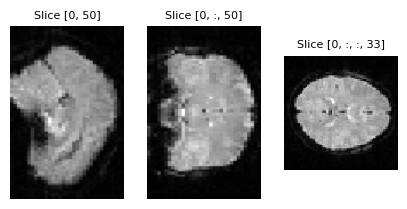

ds000001/sub-01/func/sub-01_task-balloonanalogrisktask_run-02_bold.nii.gz (64, 64, 33, 300) | TRs: 288 samp: 12
ds000001/sub-01/func/sub-01_task-balloonanalogrisktask_run-03_bold.nii.gz (64, 64, 33, 300) | TRs: 576 samp: 24
ds000001/sub-02/func/sub-02_task-balloonanalogrisktask_run-01_bold.nii.gz (64, 64, 34, 300) | TRs: 864 samp: 36
ds000001/sub-02/func/sub-02_task-balloonanalogrisktask_run-02_bold.nii.gz (64, 64, 34, 300) | TRs: 1152 samp: 48
ds000001/sub-02/func/sub-02_task-balloonanalogrisktask_run-03_bold.nii.gz (64, 64, 34, 300) | TRs: 1440 samp: 60
ds000001/sub-03/func/sub-03_task-balloonanalogrisktask_run-01_bold.nii.gz (64, 64, 34, 300) | TRs: 1728 samp: 72
ds000001/sub-03/func/sub-03_task-balloonanalogrisktask_run-02_bold.nii.gz (64, 64, 34, 300) | TRs: 2016 samp: 84
ds000001/sub-03/func/sub-03_task-balloonanalogrisktask_run-03_bold.nii.gz (64, 64, 34, 300) | TRs: 2304 samp: 96
ds000001/sub-04/func/sub-04_task-balloonanalogrisktask_run-01_bold.nii.gz (64, 64, 34, 300) | TRs: 

KeyboardInterrupt: 

In [27]:
def dataset_creation_job():
    # Start by assuming you are resuming your data creation from killed job
    # copy metadata.json from s3 to /scratch
    command = f"aws s3 cp s3://proj-fmri/fmri_foundation_datasets/{proj_name}/metadata.json {outpath}/tars/metadata.json"
    call(command,shell=True)
    
    if os.path.exists(f"{outpath}/tars/metadata.json"):
        print("Resuming...")
        with open(f"{outpath}/tars/metadata.json", 'r') as file:
            metadata = json.load(file)
    
        TR_count = metadata['TR_count']
        subj_count = metadata['subj_count']
        tar_count = metadata['tar_count'] + 1
        dataset_count = metadata['dataset_count']
        obj_key_list = metadata['obj_key_list']
        dataset_list = metadata['datasets']
        failed_dataset_dict = metadata ['failed_datasets'] if 'failed_datasets' in metadata else {}
    else:
        print("Starting from scratch!")
        tar_count = 0
        TR_count = 0
        subj_count = 0
        dataset_count = 0
        dataset_list = []
        obj_key_list = []
        failed_dataset_dict = {}
    
    print(f"TR_count: {TR_count}")
    print(f"subj_count: {subj_count}")
    print(f"tar_count: {tar_count}")
    print(f"dataset_count: {dataset_count}")
    
    # delete existing tars
    print("deleting existing tars")
    command = f"rm {outpath}/tars/*.tar"
    call(command,shell=True)
    
    TRs_per_sample = 24
    max_samples_per_tar = 320 # translates to around 1 Gb per tar
    max_TRs_per_tar = max_samples_per_tar * TRs_per_sample
    
    # Set the bucket name and folder name
    bucket_name = 'openneuro.org'
    folder_names = list_folders(bucket_name)
    NUM_DATASETS = len(folder_names)
    
    print(f"NUM_DATASETS: {NUM_DATASETS} TRs_per_sample: {TRs_per_sample} \
    max_samples_per_tar: {max_samples_per_tar} max_TRs_per_tar: {max_TRs_per_tar}")
    
    sample_idx = 0
    current_dataset = None
    current_subject = None
    sink = wds.TarWriter(f"{outpath}/tars/{tar_count:06d}.tar")
    
    tio_transforms = tio.Compose(
                    (
                        tio.ToCanonical(), # make sure orientation of brains are consistent (RAS+ orientation)
                        tio.Resample(2, image_interpolation='nearest'), # interpolate to 2mm isotropic voxel size
                    )
                )
    
    try:
        for folder_name in folder_names:
    
            if folder_name in dataset_list or folder_name in failed_dataset_dict:
                continue
    
            print(f"Processing dataset: {folder_name}.")
            # List all objects in the folder
            all_objects = list_all_objects(bucket_name, folder_name)
            for obj in all_objects:
                obj_key = obj['Key']
    
                if '_bold.nii.gz' in obj_key:
                    func_subj = obj_key.split('/')[1]
    
                    # if metadata file shows you already processed this file, skip it
                    if np.isin(obj_key, obj_key_list):
                        continue
    
                    filename = os.path.join(f'{os.getcwd()}/openneuro', obj_key)
    
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    if not os.path.exists(filename):
                        s3.download_file(bucket_name, obj_key, filename)
    
                    func_nii = nib.load(filename)
                    try:
                        print(obj_key, func_nii.get_fdata().shape, "| TRs:", TR_count, "samp:", sample_idx)
                    except Exception as e:
                        print(f"get_fdata() error occurred: {e}")
                        continue

                    # discard datasets with unusual Repetition Time
                    orig_TR = func_nii.header.get_zooms()[3]
                    if orig_TR > 10: # assuming it is in milliseconds
                        orig_TR = orig_TR / 1000
                    if orig_TR < 1 or orig_TR > 3:
                        print(f"skipped due to orig_TR = {orig_TR}")
                        error
    
                    try:
                        tio_image = tio.ScalarImage(tensor=np.moveaxis(func_nii.get_fdata(),-1,0).astype(np.float32), 
                                                affine=func_nii.affine, 
                                                dtype=np.float32)
                        out = tio_transforms(tio_image)['data']
                    except Exception as e: # this can happen if the func is actually 3d and not 4d
                        print(f"tio processing error occurred: {e}")
                        continue
    
                    # create samples of TRs_per_sample TRs
                    for batch in range(0,len(out),TRs_per_sample):
                        if len(out[batch:batch+TRs_per_sample])<TRs_per_sample:
                            continue
                        images = reshape_to_2d(out[batch:batch+TRs_per_sample])
                        images = torch.Tensor(images)
    
                        # convert tensor to something compatible with 16-bit png
                        min_, max_ = images.min(), images.max()
                        minmax_images = (images - min_) / (max_ - min_) # first you need to rescale to 0 to 1
                        rescaled_images = (minmax_images * 65535).to(torch.int16) # then multiply by constant prior to numpy uint16
                        rescaled_images_numpy = rescaled_images.numpy().astype(np.uint16)
                        PIL_image = Image.fromarray(rescaled_images_numpy, mode='I;16')
    
                        sink.write({
                            "__key__": "%06d" % sample_idx,
                            "dataset.txt": obj_key,
                            "header.npy": np.array(header_to_dict(func_nii.header)),
                            "minmax.npy": np.array([min_, max_]),
                            "func.png": PIL_image, # 27M for 8-bit png vs 48M for 16-bit png vs 144M for numpy
                        })
    
                        if current_dataset != obj['Key'].split('/')[0]:
                            print(obj_key, "| TR_count:", TR_count, "sample_idx:", sample_idx)
                            dataset_list.append(obj['Key'].split('/')[0])
                            dataset_count += 1
                            if is_interactive(): # dont want to plot unless you are in interactive notebook
                                torchio_slice(out)
    
                        if current_subject != obj['Key'].split('/')[1]:
                            subj_count += 1
                        current_dataset = obj['Key'].split('/')[0]
                        current_subject = obj['Key'].split('/')[1]
    
                        TR_count += TRs_per_sample
                        sample_idx += 1
    
                        if sample_idx >= max_samples_per_tar:
                            print("HIT MAX SAMPLES PER TAR")
                            sink.close()
                            sample_idx = 0
    
                            # make metadata file and save progress to aws s3
                            data = {
                                "TR_count": TR_count,
                                "subj_count": subj_count,
                                "tar_count": tar_count,
                                "dataset_count": dataset_count,
                                "datasets": dataset_list,
                                "obj_key_list": obj_key_list,
                                "failed_datasets": failed_dataset_dict
                            }
                            with open(f"{outpath}/tars/metadata.json", "w") as file:
                                json.dump(data, file)
    
                            # send to aws s3
                            command = f"aws s3 sync {outpath}/tars s3://proj-fmri/fmri_foundation_datasets/{proj_name}"
                            call(command,shell=True)
    
                            # delete tars
                            command = f"rm {outpath}/tars/*.tar"
                            call(command,shell=True)
    
                            tar_count += 1
                            sink = wds.TarWriter(f"{outpath}/tars/{tar_count:06d}.tar")
    
                    obj_key_list.append(obj['Key'])
    
                    # delete the nifti now that youve saved it to numpy
                    call(f"rm {filename}",shell=True)
    except Exception as e:
        failed_dataset = folder_name
        trace_str = traceback.format_exc()
        print(f"Error occurred while processing dataset {failed_dataset}: {e}")
        failed_dataset_dict[failed_dataset] = trace_str
        tar_count = metadata['tar_count']
    finally:
        print("TR_count",TR_count)
        print("subj_count",subj_count)
        print("dataset_count",dataset_count)
        print("failed_dataset_count", len(failed_dataset_dict.keys()))
        print("tar_count", tar_count)            
        try:
            sink.close()
        except:
            pass
    
        data = {
            "TR_count": TR_count,
            "subj_count": subj_count,
            "tar_count": tar_count,
            "dataset_count": dataset_count,
            "datasets": dataset_list,
            "obj_key_list": obj_key_list,
            "failed_datasets": failed_dataset_dict            
        }
    
        with open(f"{outpath}/tars/metadata.json", "w") as file:
            json.dump(data, file)
    
        # send to aws s3
        command = f"aws s3 sync {outpath}/tars s3://proj-fmri/fmri_foundation_datasets/{proj_name}"
        call(command,shell=True)
    
        # delete tars
        command = f"rm {outpath}/tars/*.tar"
        call(command,shell=True)

In [33]:
def main():
    while True:
        try:
            start_time = time.time()
            print("Starting job")
            dataset_creation_job()
            print("Finished job")
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Job took: {elapsed_time} seconds")
        except Exception as e:
            print(f"Error: {e}")
        finally:
            print("Resuming job in 5 seconds")
            time.sleep(5)

main()